# Hi class :) 
## Classification with logistic regression <span style="color: pink;">♡ Zhang Tianyi ♡</span>
#### This is a subset of my project dataset, scraped from Glassdoor, containing reviews for Fortune 500 companies with female CEOs. The subset includes reviews from 6 companies. However, I didn't use the company as a predictor since its distribution is weird within this subset. The primary focus of interest is the CEO's approval rating, denoted as 'ceo_approval'—indicating whether the reviewer approves of the CEO (1 = Yes, 0 = No). In this tutorial, I will demonstrate how to build a logistic regression model to predict whether the reviewer approves of the CEO based on the remaining information provided.



In [ ]:
import subprocess
import sys

In [1]:
!pip install afinn
from afinn import Afinn  # if this doesn't work, run the lines below

In [ ]:
# pip install saves software downloaded via pip in a "local" directory.
# you must add that directory to the system path to import it
# first run "!pip install afinn" and "!pip install mlxtend".
# then run this and you should be able to import the packages
result = subprocess.run(['pip', 'show', 'afinn'], capture_output=True, text=True, check=True)
output = result.stdout
# Parse the output to extract the location
location = None
for line in output.split('\n'):
    if line.startswith("Location:"):
        location = line.split(":")[1].strip()
sys.path.append(location)

In [4]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1.  Take a look at the data

In [5]:
# Loading data
df = pd.read_csv('clean_df.csv')
# Column names 
print(df.columns)
# Check the types of my columns
print(df.dtypes)

Index(['Unnamed: 0', '...1', 'date', 'EmployeeStatus', 'reviewer_id',
       'rating_overall.2.11.', 'rating_workfamily', 'rating_culture',
       'rating_diversity', 'rating_leadership', 'rating_opportunity',
       'rating_compensation', 'review_pros', 'review_cons', 'ceo_approval',
       'Company'],
      dtype='object')
Unnamed: 0               int64
...1                     int64
date                    object
EmployeeStatus            bool
reviewer_id              int64
rating_overall.2.11.     int64
rating_workfamily        int64
rating_culture           int64
rating_diversity         int64
rating_leadership        int64
rating_opportunity       int64
rating_compensation      int64
review_pros             object
review_cons             object
ceo_approval             int64
Company                 object
dtype: object


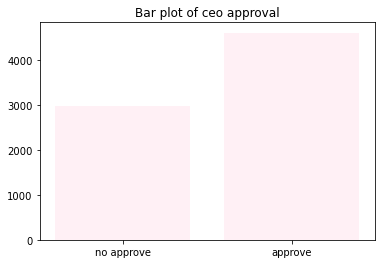

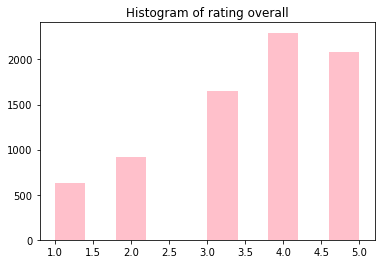

In [6]:
# transformation for bar plot creation 
app = len(np.argwhere(df.ceo_approval.to_numpy()==1))
napp = len(df.ceo_approval) - app
plt.bar(['no approve', 'approve'],[napp,app], color = 'lavenderblush')
plt.title('Bar plot of ceo approval')
plt.show()

# histogram making
plt.hist(df['rating_overall.2.11.'], color = 'pink')
plt.title('Histogram of rating overall')
plt.show()

#### From the histogram we can see that more people approve of their CEOs than disapprove. And the overall rating tends to be tailed towards the higher end (5) than the lower end (1). 

# 2. Variable transformation
#### I want to convert my features into a numerical format suitable for logistic regression. In this dataset, I have 'EmployeeStatus' coded as 'True' for individuals currently employed and 'False' for those not employed by the company. Additionally, I have 'review_pos' to store positive review text data from reviewers, and 'review_neg' to store negative reviews. My goal is to transform these three variables into numerical values. I will use a binary (1/0) coding scheme for the employee status, and I will conduct sentiment analysis (using the AFINN lexicon) to assign sentiment scores to the positive and negative reviews. 

In [9]:
# Transforming EmployeeStatus 
def bti(bool_inp):
    if bool_inp == True: return 1
    if bool_inp == False: return 0
df.EmployeeStatus = df.EmployeeStatus.apply(bti)  

# Transforming positive and negative reviews 
afn = Afinn()
pro_sent = [afn.score(article) for article in df.review_pros]
con_sent = [afn.score(article) for article in df.review_cons]
df['pro_sent'] = pro_sent
df['con_sent'] = con_sent

print(pro_sent[:5])  
print(df.EmployeeStatus[:5])    # Yay they are numbers now 

[9.0, 9.0, 5.0, 8.0, 11.0]
0    1
1    1
2    1
3    0
4    0
Name: EmployeeStatus, dtype: int64


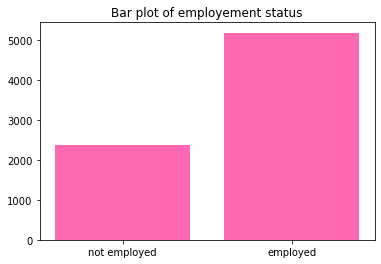

In [10]:
app = len(np.argwhere(df.EmployeeStatus.to_numpy()==1))
napp = len(df.EmployeeStatus) - app
plt.bar(['not employed', 'employed'],[napp,app], color = 'hotpink')
plt.title('Bar plot of employement status')
plt.show()    # More than half of the people in this subset are still an employee of the company

# 2. Spliting Data
#### Now that the variables are all set, I am going to separate them into training and testing sets.

In [42]:

# Keeping all of my variables of interest together 
mldf = df.drop(columns=['Unnamed: 0', '...1', 'reviewer_id','Company','date', # not interested in these variables
                        'review_cons','review_pros' # the two text variables that got transformed 
                       ])

# Separate features/predictors and target variable
X = mldf.drop('ceo_approval', axis=1)  # drop ceo_approval only
y = mldf['ceo_approval']  # keep ceo_approval only 

# Standardizing predictors 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=918)

# Display the first few rows of the training and test sets for our predictors
print("Training Data:")
print(X_train.head())
print("\nTest Data:")
print(X_test.head())     # looking good! 

Training Data:
      EmployeeStatus  rating_overall.2.11.  rating_workfamily  rating_culture  \
7304        0.676908              1.156434          -0.332736       -1.785803   
2419       -1.477305              1.156434          -0.332736        0.481660   
6421       -1.477305             -2.073135          -0.332736       -0.652072   
5526       -1.477305             -0.458351          -2.440219       -1.785803   
6328        0.676908              0.349042          -0.332736       -0.085206   

      rating_diversity  rating_leadership  rating_opportunity  \
7304         -0.782199           0.626536           -0.240953   
2419         -0.782199           0.626536            1.178146   
6421         -0.782199          -0.707408            1.178146   
5526         -0.782199          -2.041351           -2.369601   
6328         -0.782199          -0.040436           -0.240953   

      rating_compensation  pro_sent  con_sent  
7304             0.398942 -0.231760  0.523246  
2419       

# 3. Fitting model and see how well it does! 

Accuracy: 0.7940140845070423
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73       912
           1       0.80      0.87      0.84      1360

    accuracy                           0.79      2272
   macro avg       0.79      0.78      0.78      2272
weighted avg       0.79      0.79      0.79      2272



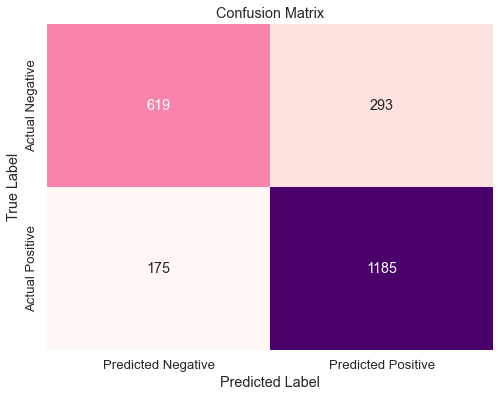

In [43]:
logit = LogisticRegression()

# Fit the model to the training data
model = logit.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = logit.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="RdPu", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [44]:
# Cross validation
cross_val_score(logit, X, y, # the function and the datasets of interest
                cv=5, # the number of subsets used
                scoring='accuracy')

array([0.78151815, 0.76948481, 0.75495376, 0.78599736, 0.75231176])

#### My model's accuracy is pretty similar to cross validation result. This suggests that my model is providing reliable and consistent predictions, and it's generalizable.

#### Knowing that my model is good, I want to see what are my important features - what predictors are effective?

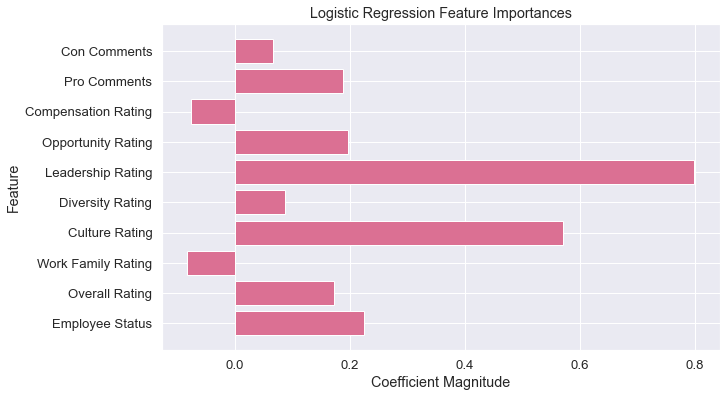

In [45]:
# Get the coefficients (weights) of the features from the trained model
coefficients = logit.coef_[0]

# Get the feature names
feature_names = ['Employee Status', 'Overall Rating', 'Work Family Rating', 'Culture Rating',
                 'Diversity Rating','Leadership Rating', 'Opportunity Rating', 
                 'Compensation Rating', 'Pro Comments', 'Con Comments']

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color = 'palevioletred')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importances')
plt.show()

#### Cool - my leadership rating and culture rating are two most effective predictors for CEO approval. Let's have them visualized in a decision region plot. 

C:\Users\tiany\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tiany\AppData\Local\Temp\ipykernel_33696\4079698148.py:48: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(scatter)


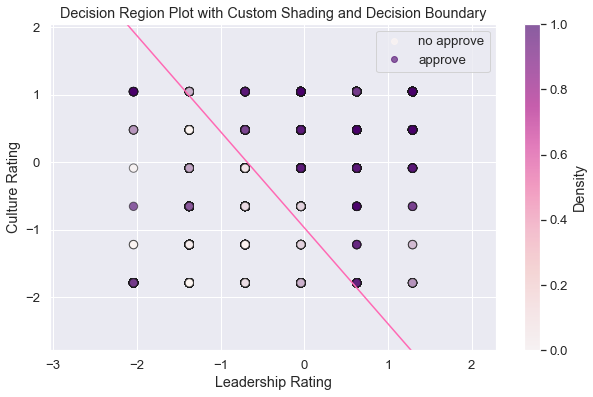

In [46]:
# Select the two features for the first visualization
X_train_selected = X_train[["rating_leadership", "rating_culture"]]

# Create and fit a new logistic regression model with only two features
model_selected = LogisticRegression()
model_selected.fit(X_train_selected, y_train)

# Create a meshgrid of values for the two selected features
# A meshgrid is a two-dimensional grid of coordinates generated from one-dimensional arrays
rating_values = np.linspace(X_train_selected["rating_leadership"].min() - 1, X_train_selected["rating_leadership"].max() + 1, 100)
employee_status_values = np.linspace(X_train_selected["rating_culture"].min() - 1, X_train_selected["rating_culture"].max() + 1, 100)
xx, yy = np.meshgrid(rating_values, employee_status_values)

# Predict the class probabilities for the meshgrid points
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model_selected.predict_proba(meshgrid_points)[:, 1]
Z = Z.reshape(xx.shape)

# Create a colormap for shading
cmap_density = plt.cm.get_cmap('RdPu') 

fig = plt.figure(1, figsize=(10, 6), facecolor='white')

# Create a scatter plot with varying shades based on density (since both my predictors are integers)
scatter = plt.scatter(
    X_train_selected["rating_leadership"],
    X_train_selected["rating_culture"],
    c=y_train,
    cmap=cmap_density,
    edgecolor='k',
    alpha=0.6,
    s=70  
)

# Plot the decision boundary with a solid line
plt.contour(xx, yy, Z, levels=[0.5], colors='hotpink')

# Set labels and title
plt.xlabel("Leadership Rating")
plt.ylabel("Culture Rating")
plt.title("Decision Region Plot with Custom Shading and Decision Boundary")

# Create a legend
legend_labels = ["no approve", "approve"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

# Show the colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label("Density")

# Show the plot
plt.show()

#### Although there are only a few dots, but color here represents the number of reviewers. Darker color represents higher density of approve, and vice versa. We can see that on the right side of the line, it's generally dark and on the left lighter. Which is similar to our intuition that lower rating would lead to less approval. 

C:\Users\tiany\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


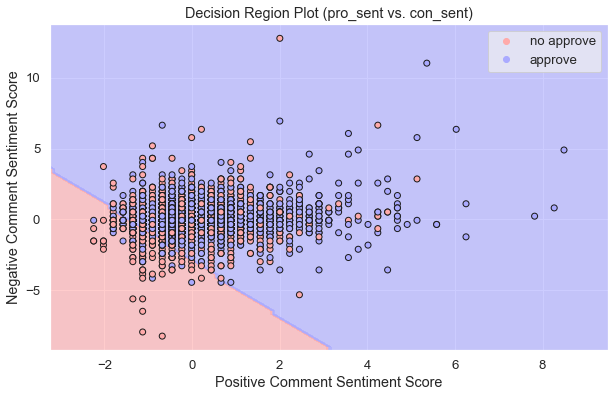

In [47]:
# Now I want to make another plot with more variation in my data and see what it looks like (with afloat values)
# Select the two features for visualization, same code as above
X_train_selected = X_train[["pro_sent", "con_sent"]]
model_selected = LogisticRegression()
model_selected.fit(X_train_selected, y_train)
pro_sent_values = np.linspace(X_train_selected["pro_sent"].min() - 1, X_train_selected["pro_sent"].max() + 1, 100)
con_sent_values = np.linspace(X_train_selected["con_sent"].min() - 1, X_train_selected["con_sent"].max() + 1, 100)

# Creating meshgrid
xx, yy = np.meshgrid(pro_sent_values, con_sent_values)

# Predict the class labels for the meshgrid points
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model_selected.predict(meshgrid_points)
Z = Z.reshape(xx.shape)


# Plotting & details
fig = plt.figure(1,figsize = (10, 6), facecolor = 'white')
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
scatter = plt.scatter(
    X_train_selected["pro_sent"],
    X_train_selected["con_sent"],
    c=y_train,
    cmap=cmap_light,
    edgecolor='k',
)
plt.xlabel("Positive Comment Sentiment Score")
plt.ylabel("Negative Comment Sentiment Score")
plt.title("Decision Region Plot (pro_sent vs. con_sent)")
legend_labels = ["no approve", "approve"]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)


plt.show()

#### Although still an integer, my sentiments scores have better values for visulization purpose. We can still get a sense of how well the model makes a decision with more complex data. 

# <span style="color: pink;">♡ Thank You ♡</span>